In [1]:
%load_ext autoreload
%autoreload 2

import sys
import json
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr

sys.path.append('..')
sys.path.append('pLMtrainer')
from pLMtrainer import utils

#torch.set_float32_matmul_precision('medium')

parquet_path = "../data/frustration/v8_frustration_v2.parquet.gzip"

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,split_test,cath_id,cath_T_id,split_old,split_0,split_1,split_2,split_3
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420,None,train,train,val,train
1,1apaA01,APTLEINTITFDVGNATINKYATFMKSIHNQAKDPTLKCYGIPMLP...,"[I, N, T, I, T, F, D, V, G, N, A, T, I, N, K, ...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[1.942, -0.924, 0.115, 1.605, 0.26, 1.182, -0....","[f6, f13, f10, f7, f10, f8, f12, f8, f12, f8, ...","[2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, ...",train,3.40.420.10,3.40.420,None,train,train,val,train


In [3]:
np.bincount(np.concatenate(df['frst_class_3'].values))

array([23390136, 90247745, 72840038])

In [4]:
np.bincount(np.concatenate(df['frst_class_3'].values)) / np.sum(np.bincount(np.concatenate(df['frst_class_3'].values)))

array([0.12543113, 0.48395942, 0.39060945])

In [5]:
train_df = df[df["split_test"] == "train"]
val_df = df[df["split_test"] == "val"]
test_df = df[df["split_test"] == "test"]

In [6]:
residues = np.concatenate(train_df["res_seq"].to_numpy())
residues

array(['E', 'D', 'R', ..., 'D', 'D', 'E'],
      shape=(167123058,), dtype=object)

In [7]:
reg_vals = np.concatenate(train_df["frst_idx"].to_numpy())
reg_vals

array([ 1.25 , -0.466,  0.868, ..., -0.807, -0.429, -1.164],
      shape=(167123058,))

In [8]:
cls_vals = np.concatenate(train_df["frst_class_3"].to_numpy())
cls_vals

array([2, 1, 2, ..., 1, 1, 0], shape=(167123058,))

In [9]:
res_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
len(res_list)

20

In [10]:
reg_dict = {}
cls_dict = {}
for res in res_list:
    mask = np.where(residues == res)
    reg_dict[res] = {
        "mean": reg_vals[mask].mean(),
        "std": reg_vals[mask].std()
    }
    bincount = np.bincount(cls_vals[mask])
    cls_dict[res] = {
        "majority_class": bincount.argmax(),
        "bincount": bincount,
        "probabilities": bincount / bincount.sum()
    }

In [11]:
reg_dict = {k: {"mean": float(v["mean"]), "std": float(v["std"])} for k, v in reg_dict.items()}
reg_dict

{'A': {'mean': 0.24633155516241328, 'std': 0.5921655729624687},
 'C': {'mean': 1.5692217918777926, 'std': 0.6959072737264238},
 'D': {'mean': -0.5126409008512032, 'std': 0.9230629461041246},
 'E': {'mean': -0.6538818506944875, 'std': 0.8268458206733751},
 'F': {'mean': 1.0376542641743833, 'std': 0.5368977355834363},
 'G': {'mean': -0.3329143674270015, 'std': 0.4180382341585831},
 'H': {'mean': -0.07303625687782933, 'std': 0.5442874863869817},
 'I': {'mean': 1.3348189110058553, 'std': 0.35411624976635797},
 'K': {'mean': -0.5991766020201935, 'std': 0.9356110787380357},
 'L': {'mean': 1.1493985180792754, 'std': 0.4078489894192925},
 'M': {'mean': 0.64248652447267, 'std': 0.5532545885213549},
 'N': {'mean': -0.527505388898922, 'std': 0.6565701459180977},
 'P': {'mean': -0.7090494259091896, 'std': 0.7200296160828458},
 'Q': {'mean': -0.6559273946801625, 'std': 0.46640159985765833},
 'R': {'mean': -0.050906470495787476, 'std': 0.8306870505452515},
 'S': {'mean': -0.3806886529441856, 'std': 

In [12]:
cls_dict = {k: {"majority_class": int(v["majority_class"]), "bincount": v["bincount"].tolist(), "probabilities": v["probabilities"].tolist()} for k, v in cls_dict.items()}
cls_dict

{'A': {'majority_class': 1,
  'bincount': [765394, 8086592, 5064374],
  'probabilities': [0.0549995832243489,
   0.5810852837954753,
   0.36391513298017586]},
 'C': {'majority_class': 2,
  'bincount': [5768, 93462, 2360815],
  'probabilities': [0.0023446725568028225,
   0.03799198795143991,
   0.9596633394917573]},
 'D': {'majority_class': 1,
  'bincount': [3724656, 4523328, 1424690],
  'probabilities': [0.3850699403288067,
   0.46763986876845015,
   0.14729019090274312]},
 'E': {'majority_class': 1,
  'bincount': [4370361, 4893760, 1101069],
  'probabilities': [0.4216382912421287,
   0.47213413357594025,
   0.10622757518193106]},
 'F': {'majority_class': 2,
  'bincount': [94698, 713978, 6126758],
  'probabilities': [0.013654228415986656,
   0.10294640537275677,
   0.8833993662112566]},
 'G': {'majority_class': 1,
  'bincount': [400187, 12000251, 472187],
  'probabilities': [0.03108822015711636,
   0.9322302949087696,
   0.03668148493411406]},
 'H': {'majority_class': 1,
  'bincount': 

In [13]:
# save the dictionaries for later use
with open('../data/frustration/reg_heuristic.json', 'w') as f:
    json.dump(reg_dict, f, indent=4)
with open('../data/frustration/cls_heuristic.json', 'w') as f:
    json.dump(cls_dict, f, indent=4)

In [14]:
### Start here

In [15]:
# load the dictionaries for later use
with open('../data/frustration/reg_heuristic.json', 'r') as f:
    reg_dict = json.load(f)
with open('../data/frustration/cls_heuristic.json', 'r') as f:
    cls_dict = json.load(f)

In [16]:
reg_dict

{'A': {'mean': 0.24633155516241328, 'std': 0.5921655729624687},
 'C': {'mean': 1.5692217918777926, 'std': 0.6959072737264238},
 'D': {'mean': -0.5126409008512032, 'std': 0.9230629461041246},
 'E': {'mean': -0.6538818506944875, 'std': 0.8268458206733751},
 'F': {'mean': 1.0376542641743833, 'std': 0.5368977355834363},
 'G': {'mean': -0.3329143674270015, 'std': 0.4180382341585831},
 'H': {'mean': -0.07303625687782933, 'std': 0.5442874863869817},
 'I': {'mean': 1.3348189110058553, 'std': 0.35411624976635797},
 'K': {'mean': -0.5991766020201935, 'std': 0.9356110787380357},
 'L': {'mean': 1.1493985180792754, 'std': 0.4078489894192925},
 'M': {'mean': 0.64248652447267, 'std': 0.5532545885213549},
 'N': {'mean': -0.527505388898922, 'std': 0.6565701459180977},
 'P': {'mean': -0.7090494259091896, 'std': 0.7200296160828458},
 'Q': {'mean': -0.6559273946801625, 'std': 0.46640159985765833},
 'R': {'mean': -0.050906470495787476, 'std': 0.8306870505452515},
 'S': {'mean': -0.3806886529441856, 'std': 

In [17]:
CNN_test = np.load("../data/it4/it4_joint_ftall_ce_test_preds.npz")
CNN_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [19]:
padded_seqs = []
for seq in CNN_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(47765,)

In [20]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(47765, 512)

In [21]:
masked_residues = seq_array[CNN_test["masks"]]
masked_residues.shape

(9736349,)

In [22]:
masked_residues

array(['S', 'S', 'T', ..., 'H', 'K', 'H'], shape=(9736349,), dtype='<U1')

In [23]:
mean_regr_preds = np.array([reg_dict[res]["mean"] for res in masked_residues])

In [24]:
majority_cls_preds = np.array([cls_dict[res]["majority_class"] for res in masked_residues])

In [25]:
mean_regr_preds.shape, majority_cls_preds.shape

((9736349,), (9736349,))

In [26]:
MAJ_report = classification_report(CNN_test["masked_cls_targets"], 
                                   majority_cls_preds, 
                                   labels=range(3), digits=4, zero_division=0)

In [27]:
np.bincount(CNN_test["masked_cls_targets"]), np.bincount(majority_cls_preds)

(array([1225372, 4764618, 3746359]), array([      0, 6679257, 3057092]))

In [28]:
print(MAJ_report)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   1225372
           1     0.6763    0.9481    0.7895   4764618
           2     0.9075    0.7406    0.8156   3746359

    accuracy                         0.7489   9736349
   macro avg     0.5279    0.5629    0.5350   9736349
weighted avg     0.6802    0.7489    0.7002   9736349



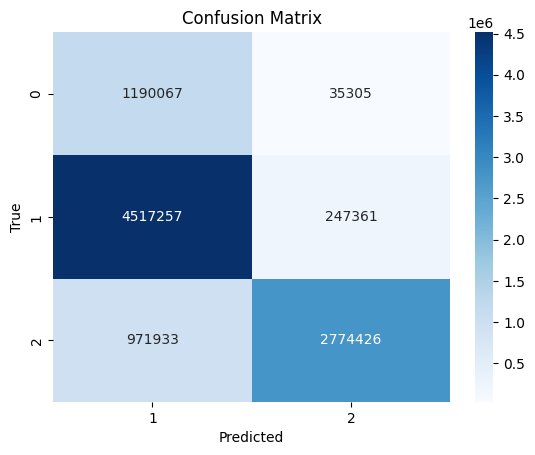

In [29]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_test["masked_cls_targets"], majority_cls_preds, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [31]:
pearsonr(CNN_test["masked_regr_targets"], mean_regr_preds), \
mean_absolute_error(CNN_test["masked_regr_targets"], mean_regr_preds), \
r2_score(CNN_test["masked_regr_targets"], mean_regr_preds)

(PearsonRResult(statistic=np.float64(0.7569819326023978), pvalue=np.float64(0.0)),
 0.44600184042260516,
 0.5728516838006006)

In [26]:
bootstrap_regr_mean = utils.bootstrapping_regression(CNN_test["masked_regr_targets"], mean_regr_preds, n_bootstrap=100)
bootstrap_regr_mean["method"] = ["Mean"] * 100

In [29]:
bootstrap_regr_df = pd.read_csv("bootstrap_regr_df.csv")
bootstrap_regr_df = pd.concat([bootstrap_regr_df, pd.DataFrame(bootstrap_regr_mean)], ignore_index=True)
bootstrap_regr_df.to_csv("bootstrap_regr_df.csv", index=False)
bootstrap_regr_df

,spearman_r,mae,r2,method
0,0.822030,0.398971,0.675051,CNN
1,0.822145,0.398782,0.675385,CNN
2,0.822131,0.399012,0.675180,CNN
3,0.822083,0.399142,0.675158,CNN
4,0.822109,0.399034,0.675241,CNN
...,...,...,...,...
295,0.681355,0.494738,0.514808,Mean
296,0.681321,0.494552,0.515019,Mean
297,0.681489,0.494258,0.515305,Mean
298,0.681383,0.494391,0.515046,Mean


In [ ]:
pd.pivot_table(bootstrap_regr_df, )

<Axes: ylabel='spearman_r'>

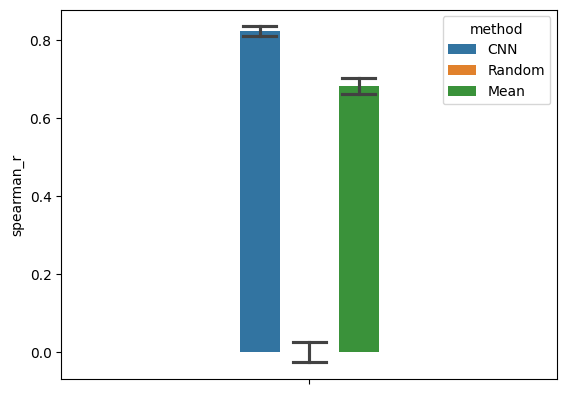

In [33]:
sns.barplot(data=bootstrap_regr_df, hue="method", y="spearman_r", errorbar=("sd", 95), capsize=.2, width=0.3, palette="tab10", gap=0.2)

In [35]:
res_df = pd.DataFrame({"regr_pred": CNN_test["masked_regr_preds"],
                       "true_reg": CNN_test["masked_regr_targets"],
                       "cls_pred": CNN_test["masked_cls_preds"],
                       "cls_target": CNN_test["masked_cls_targets"],
                       "residue": masked_residues,
                       "mean_residue_frst": mean_regr_preds,
                       "majority_cls_preds": majority_cls_preds
                       })
res_df

,regr_pred,true_reg,cls_pred,cls_target,residue,mean_residue_frst,majority_cls_preds
0,-0.065563,0.200,1,1,S,-0.380689,1
1,-0.079980,-0.313,1,1,S,-0.380689,1
2,-0.094252,-0.224,1,1,T,-0.120997,1
3,0.745904,1.238,2,2,V,1.202699,2
4,-0.427171,-0.518,1,1,G,-0.332914,1
...,...,...,...,...,...,...,...
9736344,-0.551825,-0.683,0,1,R,-0.050906,1
9736345,1.021248,1.750,2,2,F,1.037654,2
9736346,0.124221,0.138,1,1,H,-0.073036,1
9736347,-1.035922,-2.734,0,0,K,-0.599177,1


In [107]:
res_df_sub = res_df.sample(100000, random_state=42)
res_df_sub

,regr_pred,true_reg,cls_pred,cls_target,residue,mean_residue_frst,majority_cls_preds
681120,1.288539,1.275,2,2,I,1.334819,2
8239012,-0.585314,-0.728,1,1,E,-0.653882,1
8554645,0.172074,0.243,1,1,A,0.246332,1
6177741,1.288857,1.302,2,2,V,1.202699,2
674456,-0.576216,-0.970,0,1,D,-0.512641,1
...,...,...,...,...,...,...,...
4313405,1.263712,1.307,2,2,V,1.202699,2
3790609,-1.099031,-0.480,0,1,P,-0.709049,1
8651252,-0.381812,-0.564,1,1,R,-0.050906,1
9118794,1.384203,1.535,2,2,I,1.334819,2


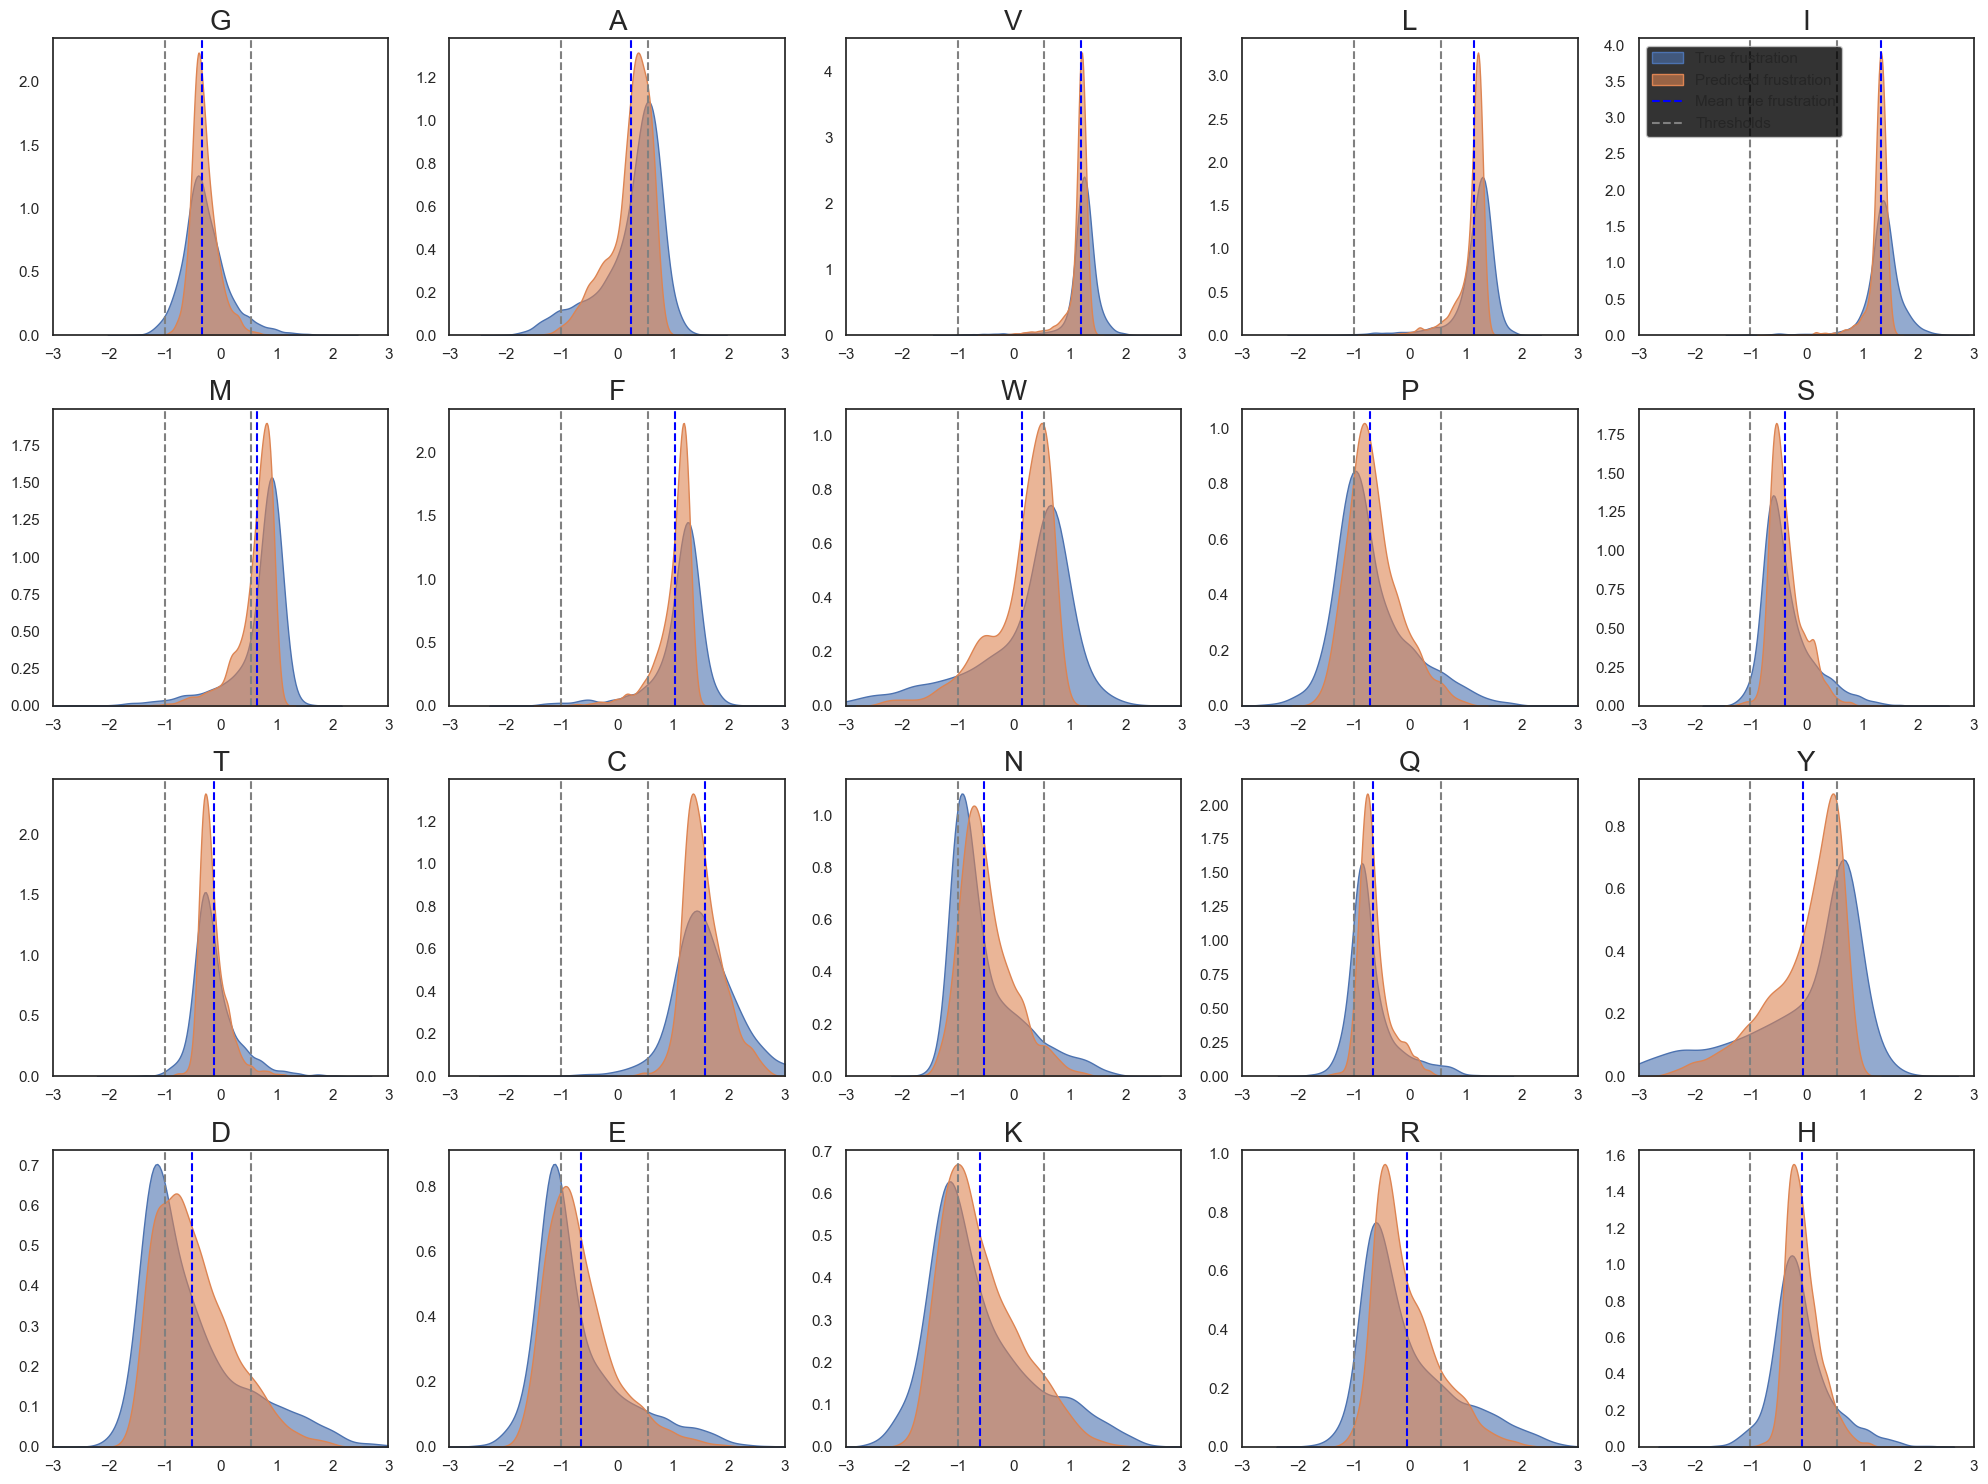

In [108]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
residues = res_df_sub["residue"].unique()
residues = ["G", "A", "V", "L", "I", "M", "F", "W", "P", "S", "T", "C", "N", "Q", "Y", "D", "E", "K", "R", "H"]
plt_legend = False
for i, residue in enumerate(residues):
    if residue == "I":
        plt_legend = True
    ax = axes[i // 5, i % 5]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    res = subset["residue"].unique()[0]
    sns.kdeplot(data=subset, x="true_reg", ax=ax, color="C0", alpha=0.6, fill=True, label="True frustration")
    sns.kdeplot(data=subset, x="regr_pred", ax=ax, color="C1", alpha=0.6, fill=True, label="Predicted frustration")
    ax.axvline(reg_dict[res]["mean"], color="blue", linestyle="--", label="Mean true frustration")
    ax.axvline(-1, color="gray", linestyle="--", label="Thresholds")
    ax.axvline(0.55, color="gray", linestyle="--")
    ax.set_xlim(-3, 3)
    ax.set_title(f'{residue}', fontsize=20)

    #ax.set_xlabel("Frustration")
    #ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.set_ylabel("")
    if plt_legend:
        plt_legend = False
        ax.legend(fontsize=11, loc="upper left")
plt.tight_layout()
plt.show()

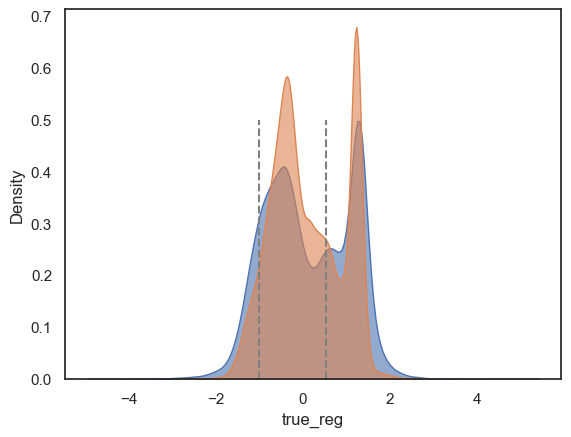

In [109]:
sns.kdeplot(data=res_df_sub, x="true_reg", color="C0", alpha=0.6, fill=True, label="True frustration")
sns.kdeplot(data=res_df_sub, x="regr_pred", color="C1", alpha=0.6, fill=True, label="Predicted frustration")
plt.vlines(x=-1, ymin=0, ymax=0.5, color="gray", linestyle="--", label="Thresholds")
plt.vlines(x=0.55, ymin=0, ymax=0.5, color="gray", linestyle="--")

In [110]:
#sort reg_dict by mean value
sorted_residues = sorted(reg_dict.items(), key=lambda x: x[1]["mean"])
sorted_residues = [res[0] for res in sorted_residues]
sorted_residues

['P',
 'Q',
 'E',
 'K',
 'N',
 'D',
 'S',
 'G',
 'T',
 'H',
 'Y',
 'R',
 'W',
 'A',
 'M',
 'F',
 'L',
 'V',
 'I',
 'C']

In [111]:
reg_dict

{'A': {'mean': 0.24633155516241328, 'std': 0.5921655729624687},
 'C': {'mean': 1.5692217918777926, 'std': 0.6959072737264238},
 'D': {'mean': -0.5126409008512032, 'std': 0.9230629461041246},
 'E': {'mean': -0.6538818506944875, 'std': 0.8268458206733751},
 'F': {'mean': 1.0376542641743833, 'std': 0.5368977355834363},
 'G': {'mean': -0.3329143674270015, 'std': 0.4180382341585831},
 'H': {'mean': -0.07303625687782933, 'std': 0.5442874863869817},
 'I': {'mean': 1.3348189110058553, 'std': 0.35411624976635797},
 'K': {'mean': -0.5991766020201935, 'std': 0.9356110787380357},
 'L': {'mean': 1.1493985180792754, 'std': 0.4078489894192925},
 'M': {'mean': 0.64248652447267, 'std': 0.5532545885213549},
 'N': {'mean': -0.527505388898922, 'std': 0.6565701459180977},
 'P': {'mean': -0.7090494259091896, 'std': 0.7200296160828458},
 'Q': {'mean': -0.6559273946801625, 'std': 0.46640159985765833},
 'R': {'mean': -0.050906470495787476, 'std': 0.8306870505452515},
 'S': {'mean': -0.3806886529441856, 'std': 

In [112]:
sorted_residues = ['P','Q','E','K','N','D','R','S','G','T','H','Y','W','A','M','F','L','V','I','C']

In [113]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# --- Order residues ---
residues = ["G", "A", "V", "L", "I", "M", "F", "W", "P", "S",
            "T", "C", "N", "Q", "Y", "D", "E", "K", "R", "H"]
residues = sorted_residues
# --- Add an ordering column so FacetGrid keeps your order ---
res_df_sub["residue"] = pd.Categorical(res_df_sub["residue"], categories=residues, ordered=True)
# Melt dataframe so ridgeplot can handle two distributions
df_melt = res_df_sub.melt(
    id_vars=["residue"],
    value_vars=["true_reg", "regr_pred"],
    var_name="type",
    value_name="frustration",
)

In [114]:
df_melt["frustration"] = df_melt["frustration"].clip(-3, 3)
df_melt["frustration"].max(), df_melt["frustration"].min()

(np.float32(3.0), np.float32(-3.0))

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


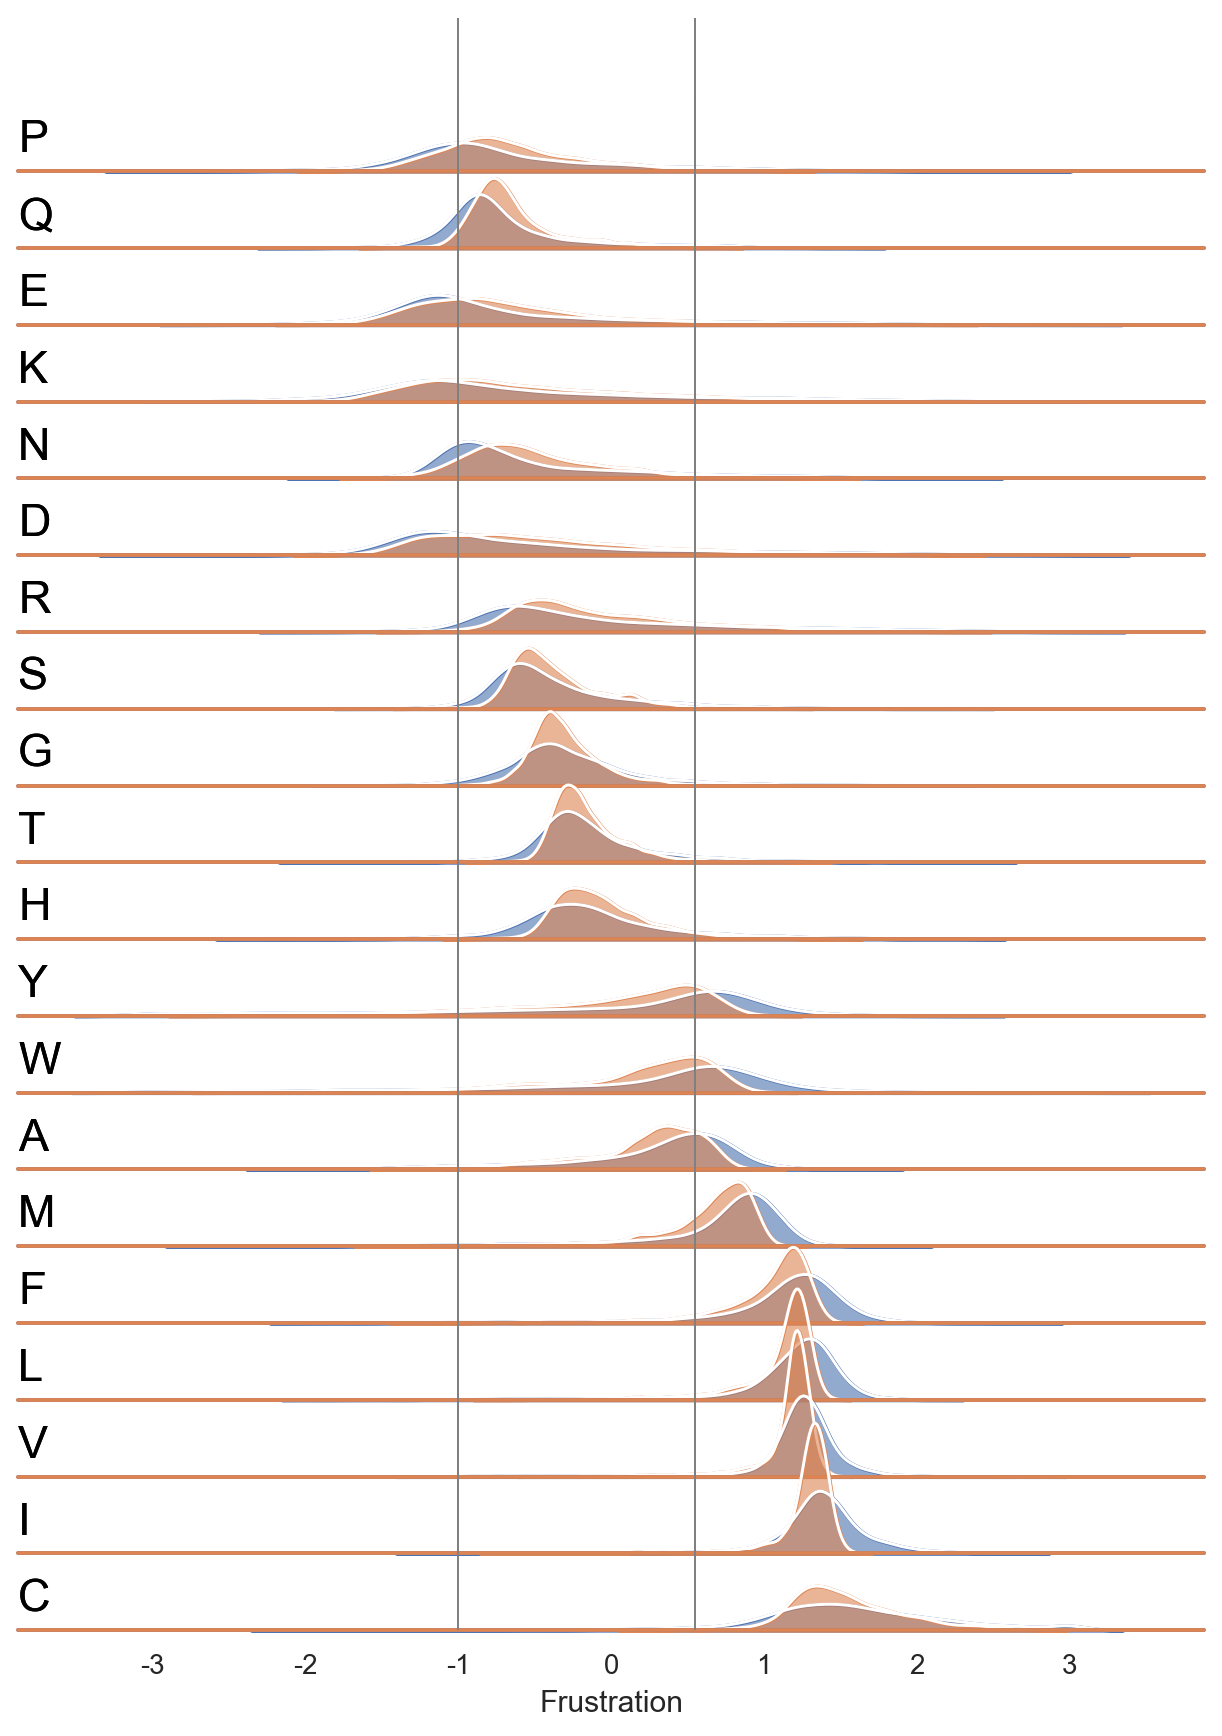

In [115]:
# Color palette for true vs predicted frustration
palette = {"true_reg": "C0", "regr_pred": "C1"}

# --- Ridge plot setup ---
g = sns.FacetGrid(df_melt,row="residue",hue="type",aspect=15,height=0.5,palette=palette,)

# KDEs
g.map(sns.kdeplot,"frustration",bw_adjust=0.8,clip_on=False,fill=True,alpha=0.6,linewidth=1.5,)

# White outline on top
g.map(sns.kdeplot,"frustration",clip_on=False,color="white",lw=1.2,bw_adjust=0.8,)

# Zero baseline for overlap
g.refline(y=0, linewidth=1.5, linestyle="-", color=None, clip_on=False)

# Optional: Add residue label on each ridge
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

def label_residue(x, color, label):
    ax = plt.gca()
    # Determine which residue corresponds to this axis
    row_i = ax.get_subplotspec().rowspan.start
    residue_name = residues[row_i]  # residues is your ordered list
    ax.text(
        0, 0.2, residue_name,
        ha="left", va="center",
        fontsize=18, color="black",
        transform=ax.transAxes
    )

g.map(label_residue, "frustration")

# Optional: Add vertical threshold lines & mean lines
def add_lines(x, color, label):
    ax = plt.gca()
    res = label  # because FacetGrid passes residue as "label"

    # thresholds
    ax.axvline(-1, color="gray", linestyle="-", linewidth=0.7)
    ax.axvline(0.55, color="gray", linestyle="-", linewidth=0.7)

    # mean true frustration for this residue
    #mean_val = reg_dict[res]["mean"]
    #ax.axvline(mean_val, color="blue", linestyle="--", linewidth=1)

g.map(add_lines, "frustration")

# Formatting
g.figure.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Frustration", xticks=np.arange(-3, 4, 1), xticklabels=[-3, -2, -1, 0, 1, 2, 3])
g.despine(bottom=True, left=True)
g.figure.set_dpi(180)

plt.show()

In [101]:
np.arange(-3, 4, 1)

array([-3, -2, -1,  0,  1,  2,  3])

<Axes: xlabel='frustration', ylabel='Density'>

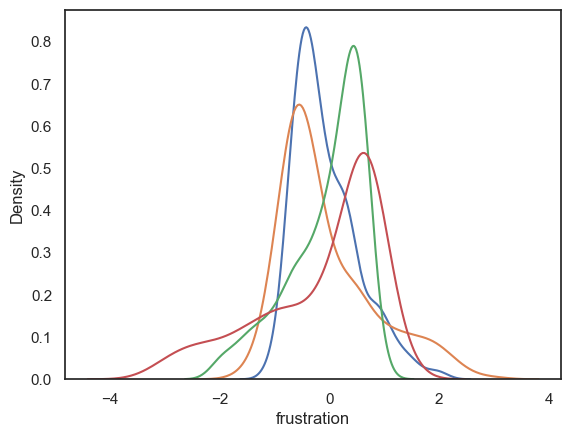

In [88]:
sns.kdeplot(df_melt.loc[(df_melt["residue"] == "R") & (df_melt["type"] == "regr_pred"), "frustration"])
sns.kdeplot(res_df_sub.loc[res_df_sub["residue"] == "R", "true_reg"])

sns.kdeplot(df_melt.loc[(df_melt["residue"] == "Y") & (df_melt["type"] == "regr_pred"), "frustration"])
sns.kdeplot(res_df_sub.loc[res_df_sub["residue"] == "Y", "true_reg"])

In [59]:
df_melt["type"] == "regr_pred"

0        False
1        False
2        False
3        False
4        False
         ...  
19995     True
19996     True
19997     True
19998     True
19999     True
Name: type, Length: 20000, dtype: bool

In [63]:
df_melt.loc[(df_melt["residue"] == "R") & (df_melt["type"] == "regr_pred"), "frustration"]

10027   -0.740054
10033   -0.575121
10058   -0.710390
10075    0.698537
10081    0.795535
           ...   
19890   -0.116279
19893   -0.348321
19917    0.298417
19974   -0.175704
19983    0.161118
Name: frustration, Length: 483, dtype: float32